# Military Aircraft Image Classification Using Custom Dataset Project

In this project we will use Transfer Learning for Image Classification. But unlike previous projects:
1. We will use our own custom dataset in this project for both training and testing
2. We will use VGG16 pre-trained complex deep learning model

Airplane images from MTARSI (Muti-type Aircraft of Remote Sensing Images, https://zenodo.org/record/3464319#.YUiSrrgzaUk) were used as dataset, but the dataset size reduced and images were rearranged for training purposes. The images of MTARSI are generally remote sensing images acquired from satellite imagery available in the Internet. 

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # For image operations
from tensorflow.keras.models import Sequential # These are required for building our new model
from tensorflow.keras.layers import Dense # These are required for building our new model
from tensorflow.keras.applications.vgg16 import VGG16  # The Transfer Learning model to be used in this project...
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from PIL import Image # Python Imaging Library - For operations like: Image open, resize image, etc..
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# First we will define our train and test image paths...
train_files_path = "airplanedataset/Train/"
test_files_path = "airplanedataset/Test/"

# Let's load any airplane image from our dataset..
img = load_img(test_files_path + "B-52/3-1.jpg")


In [3]:
# What is the size?
print(img_to_array(img).shape)

(230, 266, 3)


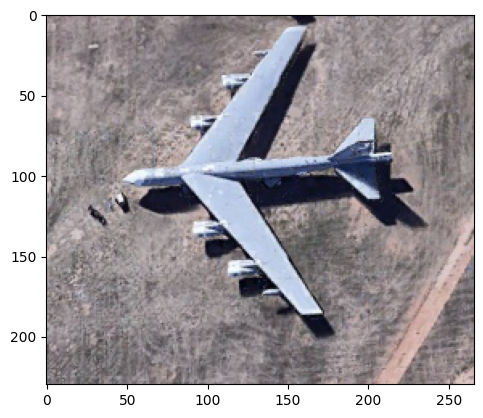

In [4]:
# Let's see this airplane, check if we can see it correctly?
plt.imshow(img)
plt.show()

### Everyting Ok. Now we should build our test and train datasets from the directories of airplane images...

In [5]:
# Let's build our train and test datasets from the directories of airplane images..
train_data = ImageDataGenerator().flow_from_directory(train_files_path,target_size = (224,224))
test_data = ImageDataGenerator().flow_from_directory(test_files_path,target_size = (224,224))


Found 1812 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [6]:
numberOfAirplaneTypes = 5  # If you have added other planes types (with airplane images in directories of course)
                           # then you must change this number...




### Building the Model 

We will use Transfer Learning, specially VGG16 model for our project!..
Bur VGG16 model has its own inputs both for training and test, therefore we should change the inputs..

Original VGG16 model is designed for ImageNet dataset (which is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories) which has 1000 image categories which are not specifically aircraft images. 
This means we will build a new model for classificiation of aircraft images in our dataset and use VGG16 pre-trained layers in this new model.

In [7]:
# Let's build our model object..
vgg = VGG16()

In [8]:
vgg_layers = vgg.layers
print(vgg_layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002949D3825E0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002949D2A9B20>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002949D2CD100>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002949D2A9FA0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002949D333DF0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002949D33B130>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002949D342490>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002949D340DF0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002949D34F250>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002949D353040>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002949D333850>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000294

In [12]:
# I'm gonna build a new Sequential model and I will add the all the layers from the Vgg16 model to my new model except 
# the last layer which is the output layer! Because I will build my own output layer according to my 
# input classes (which are the types of my military aircrafts)... 
# For this I define vggmodel_layersize_tobe_used = len(vgg_layers) - 1 (minus 1 means I omit the last layer - the output layer)
vggmodel_layersize_tobe_used = len(vgg_layers) - 1

model = Sequential()
for i in range(vggmodel_layersize_tobe_used):
    model.add(vgg_layers[i])


In [14]:
# Since I don't want to re-train all the original 16 layers of VGG16
# which has about 138 million (approx) parameters. VGG model has good train parameters, I will use them!!
for layers in model.layers:
    layers.trainable = False

# Since I have omitted the original output layer of VGG16, I have to add my new output layer to my new model!
model.add(Dense(numberOfAirplaneTypes, activation="softmax"))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [15]:
# After model design is complete, it's time to compile...
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [16]:

batch_size = 4 

model.fit_generator(train_data,
                           steps_per_epoch=400//batch_size,
                           epochs= 3, # You can increase epoch size if you have a computer with good specs...
                           validation_data=test_data,
                           validation_steps= 200//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
 57/100 [================>.............] - 5163s 91s/step - loss: 0.6919 - accuracy: 0.7969 - val_loss: 0.3283 - val_accuracy: 0.8700


 #### Please remember accuracy is the accuracy of a batch of training data and val_accuracy is the accuracy of a batch of testing data.. So we have a good 87% validation accuracy of our model with test dataset (the images our model has not seen before)

### We have good accuracy.. Now it's time to test our new Military Aircraft Recognition model with own eyes!

In [39]:
# Let's load an aircraft image and rescale it to the resolution of 224x224 which VGG16 requires..
img = Image.open("f22.jpg").resize((224,224))

In [40]:
# We must convert it to array for operations...
img = np.array(img)

In [41]:
# Let's look it's shape..
img.shape

(224, 224, 3)

In [42]:
print(img.ndim)

3


In [43]:
# We have to add an extra dimension to our array so we will reshape it.. 
img = img.reshape(-1,224,224,3)   # with reshape(-1,..) I'm adding 1 extra dimension..
                                  # I do this because my model requires 4 dim array!

In [44]:
# Let's look it's shape..
print(img.shape)
print(img.ndim)

(1, 224, 224, 3)
4


In [45]:
# I will scale input pixels between -1 and 1 using my model's preprocess_input
# VGG16 model requires it..
img = preprocess_input(img)   

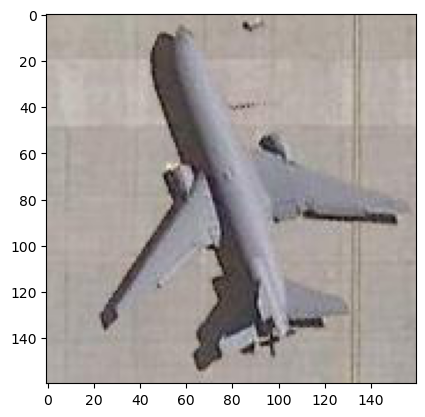

In [46]:
# Let's see the aircraft..
img_for_display = load_img("f22.jpg")
plt.imshow(img_for_display)
plt.show()

### Let's make a prediction...

In [47]:
preds = model.predict(img)


In [48]:
# Let's see contents of prediction array.. 
preds

array([[3.4019530e-03, 3.6386911e-02, 4.2729769e-02, 5.9536577e-04,
        9.1688597e-01]], dtype=float32)

These are the possibilities of each output (one-hot encoding)

Please remember the concept of Softmax:

For example, three class labels will be integer encoded as 0, 1, and 2. Then encoded to vectors as follows:

Class 0: [1, 0, 0]
Class 1: [0, 1, 0]
Class 2: [0, 0, 1]
This is called a one-hot encoding.

In our case:
A-10  Thunderbolt: [1,0,0,0,0]
Boeing B-52: [0,1,0,0,0]
.... 
like this..

For example, if the integer encoded class 1 was expected for example, the target vector would be:
[0, 1, 0]

The softmax output might look as follows, which puts the most weight on class 1 and less weight on the other classes.

For example in 3 output example above if we would have a softmax output like this: 
[0.09003057 0.67524096 0.23472847]

Then we can say the highest probability outcome is  0.67524096 which is Class 1.
I can find the index simply using numpy's argmax funxtion:

class integer = argmax([0.09003057 0.67524096 0.23472847])

In [49]:
image_classes = ["A-10 Thunderbolt","Boeing B-52","Boeing E-3 Sentry","F-22 Raptor","KC-10 Extender"]

result = np.argmax(preds[0])
print(image_classes[result]) 

KC-10 Extender
